In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

def select_hardware(
    cuda: str = None,
    cpu: str = None,
) -> None:
    os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'

    if cuda is not None:
        os.environ['CUDA_VISIBLE_DEVICES'] = cuda

    if cpu is not None:
        os.environ["MKL_NUM_THREADS"] = cpu
        os.environ["NUMEXPR_NUM_THREADS"] = cpu
        os.environ["OMP_NUM_THREADS"] = cpu

select_hardware(
    cuda="2",
    cpu="4"
)

In [3]:
import torch
from pathlib import Path
import yaml

In [4]:
logroot = Path("/scratch/jetzeschuurman/imagenet/logs")
experiment = "efficientnet_b2-256-tucker-0.75-k1x1"
run = "20211216-113721"
logdir = logroot/experiment/run


In [5]:
file_name = "args.yaml"

with open(logdir/"args.yaml", "r") as stream:
    try:
        args = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)


In [6]:
print(args['factorization'], args['fact_rank'], args['layers'])

tucker 0.75 k1x1


In [7]:
# conv_pw_layers = listify_numbered_layers(numbered_layers, layers=['conv_pw'])
conv_pw_numbers = [14, 26, 31, 45, 59, 74, 88, 102, 117, 131, 145, 159, 174, 188, 202, 216, 231, 245, 259, 273, 287, 302, 316]
conv_dw_numbers = [6, 18, 34, 48, 62, 77, 91, 105, 120, 134, 148, 162, 177, 191, 205, 219, 234, 248, 262, 276, 290, 305, 319]
conv_reduce_numbers = [10, 22, 38, 52, 66, 81, 95, 109, 124, 138, 152, 166, 181, 195, 209, 223, 238, 252, 266, 280, 294, 309, 323]
conv_expand_numbers = [12, 24, 40, 54, 68, 83, 97, 111, 126, 140, 154, 168, 183, 197, 211, 225, 240, 254, 268, 282, 296, 311, 325]
conv_pwl_numbers = [42, 56, 70, 85, 99, 113, 128, 142, 156, 170, 185, 199, 213, 227, 242, 256, 270, 284, 298, 313, 327]
k1x1 = conv_pwl_numbers + conv_expand_numbers + conv_reduce_numbers + conv_pw_numbers
layer_nrs_efficientnet_b2 = {
    'stem': [0],
    'pw': conv_pw_numbers,
    'dw': conv_dw_numbers,
    'reduce': conv_reduce_numbers,
    'expand': conv_expand_numbers,
    'pwl': conv_pwl_numbers,
    'k1x1': k1x1,
    'head': [329],
}

In [9]:
decomposed_model = torch.load(logdir/"decomposed_model.pth")
decomposed_model.cuda()

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): FactorizedConv(
            in_channels=32, out_channels=8, kernel_size=(1, 1), rank=(1, 5, 1, 1), order=2, 
            (weight): TuckerTensor(shape=(8, 32, 1, 1), rank=(1, 5, 1, 1))
          )
          (act1): SiLU(inplace=True)
          (conv_expand): FactorizedConv(
            in_channels=8, out_channels=32, kernel_size=(1, 1), rank=(5, 1, 1, 1), order=2, 
            (weight): TuckerTensor(sh

In [ ]:
pretrained_model = torch.load(logdir/"pretrained_model.pth")
pretrained_model

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
   

In [53]:
pretrained_numbered_layers = number_layers(pretrained_model)
pretrained_numbered_layers

{'conv_stem': (0,
  Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)),
 'bn1': (1,
  BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
 'act1': (2, SiLU(inplace=True)),
 'blocks': (3,
  {'0': (4,
    {'0': (5,
      {'conv_dw': (6,
        Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)),
       'bn1': (7,
        BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
       'act1': (8, SiLU(inplace=True)),
       'se': (9,
        {'conv_reduce': (10, Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))),
         'act1': (11, SiLU(inplace=True)),
         'conv_expand': (12, Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))),
         'gate': (13, Sigmoid())}),
       'conv_pw': (14,
        Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)),
       'bn2': (15,
        BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
 

In [54]:
from tddl.factorizations import number_layers
from tddl.factorizations import listify_numbered_layers

In [57]:
layer_names_k1x1 = ['conv_pw', 'conv_reduce', 'conv_expand','conv_pwl']
pretrained_conv_k1x1_layers = listify_numbered_layers(pretrained_numbered_layers, layer_names=layer_names_k1x1)
# conv_reduce_layers = listify_numbered_layers(numbered_layers, layer_names=['conv_reduce'])
# conv_expand_layers = listify_numbered_layers(numbered_layers, layer_names=['conv_expand'])
# conv_pwl_layers = listify_numbered_layers(numbered_layers, layer_names=['conv_pwl'])
# conv_pw_layers

In [89]:
pretrained_conv_k1x1_layers

90

In [86]:
decomposed_numbered_layers = number_layers(decomposed_model)
decomposed_numbered_layers

{'conv_stem': (0,
  Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)),
 'bn1': (1,
  BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
 'act1': (2, SiLU(inplace=True)),
 'blocks': (3,
  {'0': (4,
    {'0': (5,
      {'conv_dw': (6,
        Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)),
       'bn1': (7,
        BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
       'act1': (8, SiLU(inplace=True)),
       'se': (9,
        {'conv_reduce': (10, FactorizedConv(
            in_channels=32, out_channels=8, kernel_size=(1, 1), rank=(1, 5, 1, 1), order=2, 
            (weight): TuckerTensor(shape=(8, 32, 1, 1), rank=(1, 5, 1, 1))
          )),
         'act1': (11, SiLU(inplace=True)),
         'conv_expand': (12,
          FactorizedConv(
            in_channels=8, out_channels=32, kernel_size=(1, 1), rank=(5, 1, 1, 1), order=2, 
            (weight): Tuck

In [88]:
decomposed_conv_k1x1_layers = listify_numbered_layers(decomposed_numbered_layers, layer_names=layer_names_k1x1)
len(decomposed_conv_k1x1_layers)

90

In [81]:
[x for x in decomposed_model.blocks[0][0].se.conv_reduce.named_modules()]

[('',
  FactorizedConv(
    in_channels=32, out_channels=8, kernel_size=(1, 1), rank=(1, 5, 1, 1), order=2, 
    (weight): TuckerTensor(shape=(8, 32, 1, 1), rank=(1, 5, 1, 1))
  )),
 ('weight', TuckerTensor(shape=(8, 32, 1, 1), rank=(1, 5, 1, 1))),
 ('weight.factors',
  FactorList(
      (factor_0): Parameter containing: [torch.FloatTensor of size 8x1]
      (factor_1): Parameter containing: [torch.FloatTensor of size 32x5]
      (factor_2): Parameter containing: [torch.FloatTensor of size 1x1]
      (factor_3): Parameter containing: [torch.FloatTensor of size 1x1]
  ))]

In [83]:
decomposed_model.blocks[0][0].se.conv_reduce._get_name()

'FactorizedConv'

In [85]:
print(decomposed_model.blocks[0][0].se.conv_reduce)


FactorizedConv(
  in_channels=32, out_channels=8, kernel_size=(1, 1), rank=(1, 5, 1, 1), order=2, 
  (weight): TuckerTensor(shape=(8, 32, 1, 1), rank=(1, 5, 1, 1))
)


In [121]:
import tensorly as tl
tl.set_backend('pytorch')

def relative_error(pre_weight, dec_weight):
    with torch.no_grad():
        return tl.norm(pre_weight-dec_weight)/tl.norm(pre_weight)

In [129]:
errors_conv_k1x1 = {
    'name': [],
    'nr': [],
    'error': [],
}

for pre, dec in zip(pretrained_conv_k1x1_layers,decomposed_conv_k1x1_layers):
    
    if pre[0] != dec[0]:
        print(f'breaking: {pre[0]} != {dec[0]}')
        break
    if pre[1] != dec[1]:
        print(f'breaking: {pre[1]} != {dec[1]}')
        break
    
    name = pre[0]
    nr = pre[1]

    pre_weight = pre[2].weight
    dec_weight = dec[2].weight.to_tensor()

    error = relative_error(pre_weight, dec_weight)
    
    errors_conv_k1x1['name'].append(name)
    errors_conv_k1x1['nr'].append(nr)
    errors_conv_k1x1['error'].append(float(error))

In [110]:
pre_weight = pretrained_conv_k1x1_layers[0][2].weight

In [111]:
dec_weight = decomposed_conv_k1x1_layers[0][2].weight.to_tensor()

In [124]:
errors = [e[2] for e in errors_conv_k1x1_layers]

In [127]:
import pandas as pd

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [144]:
df_errors = pd.DataFrame(data=errors_conv_k1x1)
df_errors

,name,nr,error
0,conv_reduce,10,0.828350
1,conv_expand,12,0.765909
2,conv_pw,14,0.626045
3,conv_reduce,22,0.662163
4,conv_expand,24,0.691187
...,...,...,...
85,conv_pwl,313,0.840699
86,conv_pw,316,0.860006
87,conv_reduce,323,0.967244
88,conv_expand,325,0.846420


In [146]:
df_errors.set_index('nr', inplace=True)


KeyError: "None of ['nr'] are in the columns"

name
conv_expand    AxesSubplot(0.125,0.125;0.775x0.755)
conv_pw        AxesSubplot(0.125,0.125;0.775x0.755)
conv_pwl       AxesSubplot(0.125,0.125;0.775x0.755)
conv_reduce    AxesSubplot(0.125,0.125;0.775x0.755)
Name: error, dtype: object

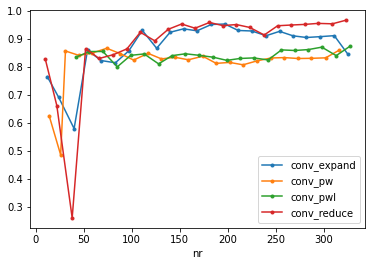

In [150]:
grouped_errors = df_errors.groupby(by='name')
grouped_errors['error'].plot(legend=True, style=".-")

name
conv_expand    AxesSubplot(0.125,0.125;0.775x0.755)
conv_pw        AxesSubplot(0.125,0.125;0.775x0.755)
conv_pwl       AxesSubplot(0.125,0.125;0.775x0.755)
conv_reduce    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

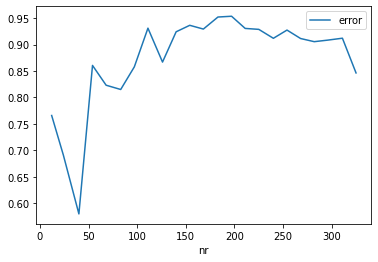

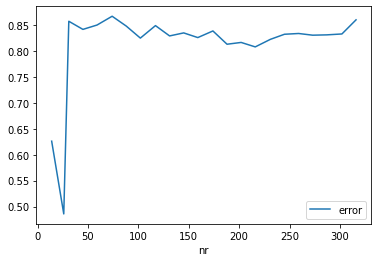

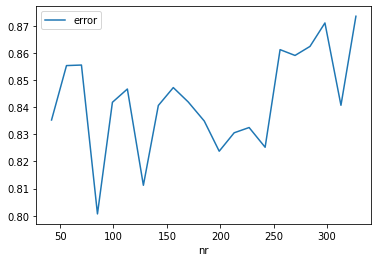

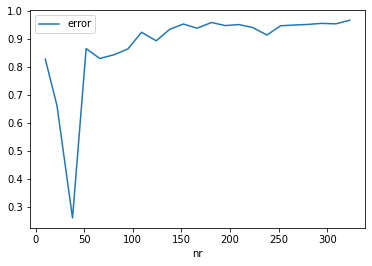

In [141]:
grouped_errors.plot(x='nr', y='error')

<AxesSubplot:xlabel='nr'>

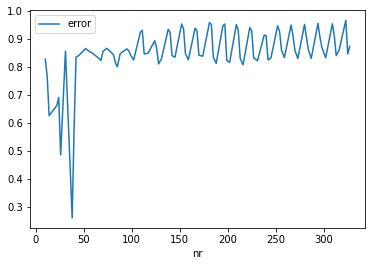

In [140]:
df_errors.plot(x='nr', y='error')